# Homework 7: Recurrent Neural Networks

In this homework, you will implement a simple Recurrent Neural Network (RNN) that processes an input sequence $x=\{x_1, \cdots, x_T\}$ to generate an output sequence $y=\{y_1, \cdots, y_T\}$. The tasks includes
- Tanh and softmax
- Forward propogation
- Backpropogation through time
- RNN class

## 0 - Import Libraries and Tanh [1/1]

In this assingment, we only use `numpy` to implement RNN and `matplotlib` for plot.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

As discussed in the lectures, the Tanh activation function is commonly used in Natural Language Processing (NLP). Here, you’ll define a class `Tanh` with two methods: `forward()` for activation and `derivative()` for computing gradients during backpropagation.

$$
\tanh(x) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}
$$

**Exercise [0.5/0.5]**: Implement class `Tanh`.

In [ ]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, x):
        ### Code Here ###

        ### Code Here ###

    def derivative(self, x):
        ### Code Here ###

        ### Code Here ###

    def __call__(self, x):
        return self.forward(x)

In [ ]:
## Test Tanh
act = Tanh()
x = np.random.randn(2,3)
print(f"act(x) =\n {act(x)}")
print(f"act.derivative(x) =\n {act.derivative(x)}")

act(x) =
 [[ 0.92525207 -0.5453623  -0.48398233]
 [-0.79057703  0.69903334 -0.98015695]]
act.derivative(x) =
 [[0.1439086  0.70257996 0.76576111]
 [0.37498795 0.51135239 0.03929236]]


Additionally, we will define the Softmax activation to compute the output $\hat{y}$.

Note: The input $x$ has shape `(batch_size, input_size)`. Your implementation should ensure the output `y = softmax(x)` retains the shape `(batch_size, input_size)`, and the sum of `y` across each sample should be `1`.

**Exercise [0.5/0.5]**: Implement softmax.

In [ ]:
def softmax(x):
    ### Code Here ###

    ### Code Here ###

In [ ]:
## Test softmax
x = np.random.randn(4,5)
y = softmax(x)
print(f"softmax(x) =\n {y}")
print(f"sum of y for each sample =\n {np.sum(y, axis=1, keepdims=True)}")


softmax(x) =
 [[0.18376865 0.4103551  0.03269533 0.28088273 0.09229819]
 [0.17606771 0.11032588 0.11556621 0.08852581 0.50951439]
 [0.39110427 0.27540117 0.05782917 0.19338811 0.08227728]
 [0.10790932 0.17883443 0.21565153 0.24922814 0.24837658]]
sum of y for each sample =
 [[1.]
 [1.]
 [1.]
 [1.]]


## 1 - Implement Recurrent Neural Network


### 1.1 Initialization [1/1]

Recall that we initialize the weights and bias in MLP using random initializaiton. Here we do the same random initializaiton for RNN. Specifically, for a weight matrix $W\in \mathbb{R}^{m\times n}$, each entry is randomly initialized using an i.i.d. Gaussian distribution:
$$
W_{ij}\sim N\left(0,\frac{2}{n+m}\right)
$$
We are fine to use zero initializaiton for bias. Note that in RNN, we have three weight matrices shared across all time steps: $W_x\in \mathbb{R}^{n_h\times n_x}$, $W_y\in \mathbb{R}^{n_y\times n_h}$, and $W_h\in \mathbb{R}^{n_h \times n_h}$.

**Exercise [2/2]**: Implement `initialize_rnn_parameters` to randomly initilaize weights `Wx`, `Wy`, `Wh`, and biases `bh` and `by`. Return a dictionary `parameters` that contains all parameters.

In [ ]:
# Initialize weights and biases
def initialize_rnn_parameters(n_x, n_h, n_y):
    parameters = {}
    ### Code Here ###

    ### Code Here ###

    parameters['Wx'] = Wx
    parameters['Wh'] = Wh
    parameters['Wy'] = Wy
    parameters['bh'] = bh
    parameters['by'] = by
    return parameters

In [ ]:
# Test initialize_rnn_parameters
np.random.seed(1)
n_x = 3
n_h = 9
n_y = 5
parameters = initialize_rnn_parameters(n_x, n_h, n_y)
print("Wx:", parameters['Wx'])
print("Wh:", parameters['Wh'])
print("Wy:", parameters['Wy'])

Wx: [[ 0.66313622 -0.24974851 -0.21562521]
 [-0.43803761  0.35330119 -0.93959924]
 [ 0.71231642 -0.31076142  0.13024717]
 [-0.10180503  0.59690307 -0.84104892]
 [-0.13162627 -0.15678953  0.46285944]
 [-0.44902873 -0.07039352 -0.3583842 ]
 [ 0.01723369  0.23793331 -0.4493259 ]
 [ 0.4673315   0.36807287  0.20514245]
 [ 0.3677729  -0.27913073 -0.05016972]]
Wh: [[-0.31192314 -0.08929603  0.17678516 -0.23055358 -0.13225118 -0.22905757
  -0.28173521 -0.22374871 -0.00422153]
 [-0.37243678  0.07813857  0.55326739  0.24734805 -0.06394518 -0.29587632
  -0.24905276  0.56415153  0.01693592]
 [-0.21233188  0.06363849  0.70008505  0.04005298  0.20573437  0.10005677
  -0.11741662 -0.3808394  -0.11644757]
 [-0.06963141  0.19554106  0.27966114  0.31036736  0.09519578  0.29504705
  -0.25146598  0.41762272  0.17097661]
 [-0.09936428  0.16283938 -0.02519057  0.3772098   0.50660561  0.72852514
  -0.46549878 -0.48137127 -0.16815529]
 [ 0.05334569  0.29205631  0.10521165 -0.67406707 -0.102068    0.27599155
 

### 1-2 RNN Layer [2/2]

implement RNN. Recall that give a sequence $\{x_1, \dots, x_T\}$, a RNN unit take a hidden state vector $h_{t-1}$ from previous layer and the current input $x_t$ from the sequence, then update the hidden state
$$
h_t = \tanh(W_h h_{t-1} + W_x x_t + b_h)
$$
Then this update hidden state is used to compute the output at time $t$:
$$
\hat{y}_t = \text{softmax}(W_y h_t + b_y)
$$

However, to facility backpropogation, we will introduce extra intermediate variables and their values will be stored in the `cache` that will be used in backpropogation to compute the gradients.

$$
\begin{align}
&z_t = W_h h_{t-1} + W_x x_t + b_h\\
&h_t = \phi(z_t)\\
&u_t = W_y h_t + b_y\\
&\hat{y}_t = \text{softmax}(u_t)
\end{align}
$$
Note that we will not store the values of $u_t$, since it does not explicitly use thanks to the combination of cross entropy loss and softmax. Thus, we only need to return `yhat_t`, `h_t`, and `z_t`.

**Exercise [2/2]**: Implement one layer RNN `rnn_layer` with input `x_t` and `h_prev`, and `parameters`. Return the `yhat_t`, `h_t`, and `z_t`

In [ ]:
def rnn_layer(x_t, h_prev, parameters, act=Tanh()):
    # xt: input at time t, shape (batch_size, input_size)
    # h_prev: previous hidden state, shape (batch_size, hidden_size)
    # Wh: weights for hidden to hidden, shape (hidden_size, hidden_size)
    # Wx: weights for input to hidden, shape (hidden_size, input_size)
    # Wy: weights for hidden to output, shape (output_size, hidden_size)
    # bh: bias for hidden state, shape (hidden_size, 1)
    # by: bias for output, shape (output_size, 1)

    Wh = parameters['Wh']
    Wx = parameters['Wx']
    Wy = parameters['Wy']
    bh = parameters['bh']
    by = parameters['by']

    ### Code Here ###

    ### Code Here ###

    return yhat_t, h_t, z_t

In [ ]:
# Test rnn_layer()
np.random.seed(1)
batch_size = 2
x = np.random.randn(batch_size, n_x)
pre_h = np.random.randn(batch_size, n_h)

y_t, h_t, z_t = rnn_layer(x, pre_h, parameters)
print("y_t.shape:", y_t.shape)
print("y_t:", y_t)

y_t.shape: (2, 5)
y_t: [[2.31497458e-04 9.24265539e-03 9.75012681e-01 1.44409055e-02
  1.07226113e-03]
 [1.08739880e-05 9.99969433e-01 1.37498024e-08 4.22887287e-06
  1.54503763e-05]]


### 1-3 RNN Forward Pass [2/2]

Now, we are ready to build the `forward()` pass for RNN. Given `inputs`, we stack the `rnn_layer` w.r.t. the `sequence_length`. We store all the intermediate values `h_t`, `yhat_t`, `z_t`, and `x_t` are stored in the `cache`. At the end, we return the output `yhats` and `cache`.

**Exercise [2/2]**: Implement `forward()` by stackin the `rnn_layer` and return the outputs `yhats` and `cache` that stores `hs`, `zs`, `yhats`, and `inputs`.

In [ ]:
def forward(inputs, parameters, act=Tanh()):
    # inputs: (batch_size, sequence_length, input_size)
    # parameters: dictionary, containing (Wh, Wx, Wy, bh, by)
    batch_size, sequence_length, input_size = inputs.shape
    hidden_size = parameters['Wh'].shape[0]
    output_size = parameters['Wy'].shape[0]

    # Initialize outputs, hidden states, pre activation
    yhats = np.zeros((batch_size, sequence_length, output_size))
    hs = np.zeros((batch_size, sequence_length, hidden_size))
    zs = np.zeros((batch_size, sequence_length, hidden_size))

    # Initialize the previous hidden state
    h_prev = np.zeros((batch_size, hidden_size))

    # Loop through each time step
    for t in range(sequence_length):
        # Extract the input at time t and perform RNN layer calculations
        ### Code Here ###

        ### Code Here ###

        # Store the results and Update the previous hidden state
        ### Code Here ###

        ### Code Here ###

    # Cache the intermediate values
    ### Code Here ###

    ### Code Here ###

    return yhats, cache

In [ ]:
## Test
np.random.seed(1)
batch_size = 7
sequence_length = 2
n_x = 3
n_h = 9
n_y = 5

x = np.random.randn(batch_size, sequence_length, n_x)
parameters = initialize_rnn_parameters(n_x, n_h, n_y)

outputs, cache = forward(x, parameters)
print("y_pred.shape:", outputs.shape)
print("y_pred:", outputs)

y_pred.shape: (7, 2, 5)
y_pred: [[[8.14030433e-01 1.85697573e-01 1.19428504e-04 1.50260441e-04
   2.30558817e-06]
  [9.15500527e-01 5.76525372e-04 8.38080431e-02 7.74767803e-05
   3.74277242e-05]]

 [[2.25965257e-01 7.70775868e-01 1.28454261e-03 1.82887200e-03
   1.45460715e-04]
  [7.46652214e-01 9.38900248e-03 2.41129282e-01 2.58439814e-03
   2.45103162e-04]]

 [[6.74700721e-04 2.42456728e-02 2.17135742e-02 1.73002039e-01
   7.80364014e-01]
  [8.76059591e-01 1.12555365e-01 9.12727590e-03 1.98127191e-03
   2.76496978e-04]]

 [[7.75369988e-01 1.82259822e-02 1.86318767e-01 1.21015190e-02
   7.98374302e-03]
  [2.08883982e-05 9.38296085e-05 2.43152289e-02 2.77351744e-02
   9.47834879e-01]]

 [[6.52061336e-01 3.45708061e-01 5.87547698e-04 1.58770786e-03
   5.53476937e-05]
  [4.03010060e-02 1.03779191e-02 7.59748679e-01 8.62274703e-02
   1.03344925e-01]]

 [[9.56819502e-01 3.64582631e-02 3.55765118e-03 2.85283239e-03
   3.11751088e-04]
  [7.69509091e-01 1.84469051e-02 2.83176522e-02 9.554872

### 1-4 Compute Cost [1/1]

Now let us compute the cost using cross entropy loss. Note that we have target sequence $y=(y_1, \dots, y_T)$ and output sequence $\bar{y}=(\bar{y}_1, \dots, \bar{y}_T)$, where each $y_t$ and $\bar{y}_t$ are a $n_y\times 1$ vector. Their cross entropy loss at time $t$ is
$$
\ell(y_t, \bar{y}_t) = -y_t \cdot \log \bar{y}_t
$$
Then the coss across all time is
$$
\ell(y, \bar{y}) = \frac{1}{T}\sum_{t} \ell(y_t, \bar{y}_t)
$$
Considering all training sample, we have
$$
L = \frac{1}{N}\sum_{i=1}^{N} \ell(y^{(i)}, \bar{y}^{(i)}) = \frac{1}{NT}\sum_{i=1}^{N}\sum_{t=1}^{T} \ell(y_t^{(i)}, \bar{y}_t^{(i)})
=-\frac{1}{NT} \sum_{i=1}^{N}\sum_{t=1}^{T} y_t \cdot \log \bar{y}_t
$$

**Exercise [1/1]**: Implemente the `compute_cost()`

In [ ]:
def compute_cost(targets, outputs):
    # Compute the cross-entropy loss for the predicted outputs
    # targets: (batch_size, sequence_length, output_size)
    # outputs: (batch_size, sequence_length, output_size)
    batch_size, sequence_length, output_size = targets.shape

    # Compute the cross-entropy loss
    ### Code Here ###

    ### Code Here ###
    return loss

In [ ]:
def generate_one_hot_targets(batch_size, sequence_length, n_y):
    random_class_indices = np.random.randint(0, n_y, size=(batch_size, sequence_length))
    one_hot_targets = np.zeros((batch_size, sequence_length, n_y))
    one_hot_targets[np.arange(batch_size)[:, None], np.arange(sequence_length), random_class_indices] = 1
    return one_hot_targets

np.random.seed(123)
targets = generate_one_hot_targets(batch_size, sequence_length, n_y)
loss = compute_cost(targets, outputs)
print("loss:", loss)

loss: 5.676070798625509


### 1-5 Backpropogation [3/3]

Recall that we have forward
$$
\begin{align}
z_t = &W_h h_{t-1} + W_x x_t + b_h\\
h_t = &\phi(z_t)\\
u_t = & W_y h_t + b_y\\
\bar{y}_t = & \text{softmax}(u_t)
\end{align}
$$

Using chain rule, we have
$$
\begin{align}
&du_t= \bar{y}_t-y_t\\
&dW_y = d u_t h_t^{\top}\\
&db_y = d u_t\\
&dh_t = W_y^{\top} d u_t + W_h^{\top} dz_{t+1} \\
&dz_t = \phi^{\prime}(z_t) \odot dh_t\\
&dW_h = dz_t h_{t-1}^{\top}\\
&dW_x = dz_t x_t^{\top}\\
&db_h = dz_t
\end{align}
$$
We can see we need to pass $d z_t$ to the next time step for back propogate.

To use vectorizaiton, suppose `x_t` is a batch of input with shape `(batch_size, input_size)`. Then the forward becomes
$$
\begin{align}
&Z_t = H_{t-1}W_h^{\top} + X_t W_x^{\top} + e b_h^{\top} \\
&H_t = \phi(Z_t)\\
&U_t = H_t W_y^{\top} + e b_y^{\top}\\
&\bar{Y}_t = \text{softmax}(U_t)
\end{align}
$$
where
$$
\begin{align}
Z_t = \begin{bmatrix}
z_t^{(1)} & z_t^{(2)} & \cdots & z_t^{(N)}
\end{bmatrix}
^{\top}
\in \mathbb{R}^{N\times n_h},
\quad
e =
\begin{bmatrix}
1 & 1 & \cdots & 1
\end{bmatrix}^{\top}
\in \mathbb{R}^{N\times 1}
\end{align}
$$
Then the gradients become
$$
\begin{align}
&dU_t =\frac{1}{NT} (\bar{Y}_t - Y_t)\\
&dW_y = \sum_t dU_t^{\top} H_t\\
&db_y = \sum_t dU_t^{\top} e\\
&dH_t = dU_t W_y+ dZ_{t+1} W_h\\
&dZ_t = \phi^{\prime}(Z_t) \odot dH_t\\
&dW_h = \sum_t (dZ_t)^{\top} H_{t-1}\\
&dW_x = \sum_t (dZ_t)^{\top} X_t\\
&db_h = \sum_t (dZ_t)^{\top} e
\end{align}
$$
**Note**: because the weights and baises are shared across all steps. The gradients are also accumulated across all time steps.

**Exercise [3/3]**: Impelente `backward()` method and return `grads`.

In [ ]:
def backward(y, parameters, caches, act_derivative=Tanh().derivative):
    # y: (batch_size, sequence_length, output_size)
    # parameters: dictionary, containing (Wh, Wx, Wy, bh, by)
    # caches: dictionary, containing (yhats, hs, zs, inputs)

    batch_size, sequence_length, output_size = y.shape
    hidden_size = parameters['Wh'].shape[0]
    input_size = parameters['Wx'].shape[1]

    Wy = parameters['Wy']
    Wh = parameters['Wh']
    Wx = parameters['Wx']
    bh = parameters['bh']
    by = parameters['by']

    # Initialize gradients
    dWh = np.zeros_like(parameters['Wh'])
    dWx = np.zeros_like(parameters['Wx'])
    dWy = np.zeros_like(parameters['Wy'])
    dbh = np.zeros_like(parameters['bh'])
    dby = np.zeros_like(parameters['by'])
    grads ={}

    dz_t_next = np.zeros((batch_size, hidden_size))
    for t in reversed(range(sequence_length)):
        # Retrieve cached values for current time step
        ### Code Here ###

        ### Code Here ###

        # Handle previous hidden state (use zeros if t=0)
        ### Code Here ###

        ### Code Here ###

        # Compute output error
        ### Code Here ###

        ### Code Here ###

        # Compute gradients for output weights and biases
        ### Code Here ###

        ### Code Here ###

        # Backpropagate error to hidden state
        ### Code Here ###

        ### Code Here ###

        # Compute gradient w.r.t. pre-activation z_t
        ### Code Here ###

        ### Code Here ###

        # Compute gradients for hidden-to-hidden weights, input-to-hidden weights, and biases
        ### Code Here ###

        ### Code Here ###

        # Update dz_t_next
        ### Code Here ###

        ### Code Here ###

    grads['dWh'] = dWh
    grads['dWx'] = dWx
    grads['dWy'] = dWy
    grads['dbh'] = dbh
    grads['dby'] = dby

    return grads

In [ ]:
## Test
grads = backward(targets, parameters, cache)
print("grads['dWx'].shape:", grads['dWx'].shape)
print("grads['dWx']:", grads['dWx'])

grads['dWx'].shape: (9, 3)
grads['dWx']: [[-0.59072159  0.40433816  1.10746108]
 [ 0.958936    0.05239214  1.00942008]
 [-0.5482359   0.32950661 -1.2185552 ]
 [ 0.28912497  0.23787591 -3.48232618]
 [-1.60721343  0.91352167  0.52073181]
 [ 0.72894355 -0.49311288  0.55852002]
 [-0.04680902 -0.37165716  2.42702709]
 [ 1.07534461 -0.60867996  1.19172103]
 [-0.96090388  0.4181982   0.33683314]]


### 1.6 Build RNN [1/1]

Now that we have all the components, it is time to build the `RecurrentNeuralNetwork` class. It has three essential methods
- `initialize_parameters` random initialize each weights and zero initialize biases
- `forward()`: given `inputs`, we use `self.parameters` to compute the `outputs` and return. Meanwhile, we store the intermediate values in `self.cache`.
- `backward()`: Employ backpropogation through time to compute the gradients for weights and biases.

Exercise [1/1]: Implement the `RecurrentNeuralNetwork` class.

In [ ]:
class RecurrentNeuralNetwork:
    def __init__(self, input_size, output_size, hidden_size, act=Tanh()):
        # Save input parameters to attributes and initialize parameters
        ### Code Here ###

        ### Code Here ###

    def initialize_parameters(self):
        self.parameters = {}
        ### Code Here ###

        ### Code Here ###

    def forward(self, inputs):
        self.caches = {}
        ### Code Here ###

        ### Code Here ###
        return outputs

    def backward(self, y):
        self.grads = {}
        ### Code Here ###

        ### Code Here ###
        self.grads = grads

    def __call__(self, inputs):
        return self.forward(inputs)

In [ ]:
# Test Recurrent NeuralNetwork and its forward()
np.random.seed(1)
n_x = 3
n_h = 9
n_y = 5
batch_size = 4
sequence_length = 2
x = np.random.randn(batch_size, sequence_length, n_x)
y = generate_one_hot_targets(batch_size, sequence_length, n_y)

network = RecurrentNeuralNetwork(n_x, n_y, n_h)

outputs = network(x)
print(f"Shape of outputs: {outputs.shape}")
# print(f"outputs = \n{outputs}")

Shape of outputs: (4, 2, 5)


In [ ]:
# Test the backward() method in NeuralNetwork
network.backward(y)
print(f"Shape of grads: {network.grads['dWx'].shape}")
print(f"grads['dWx'] = \n{network.grads['dWx']}")

Shape of grads: (9, 3)
grads['dWx'] = 
[[-0.33408226  0.20717265 -0.17950987]
 [ 0.42339331  0.24859148  0.09659816]
 [ 0.85870903 -0.41918044  0.00496727]
 [ 0.45031315 -0.47297622  0.71640565]
 [ 0.52565742 -0.23802471  0.01545178]
 [ 0.06318471 -0.34500968  0.19753802]
 [-0.01849903  0.19205179  0.17765888]
 [ 0.23638977 -0.05530361 -0.19717733]
 [ 0.67169325 -0.48560953  0.41511517]]


## 2 - Training RNN using Gradient Descent

We now can train the RNN using gradient descent.

In [ ]:
def gradient_descent_step(parameters, grads, learning_rate):
    for key in parameters.keys():
        parameters[key] -= learning_rate * grads[f'd{key}']

In [ ]:
gradient_descent_step(network.parameters, network.grads, learning_rate=0.01)

for key in network.parameters:
    print(f"{key} = \n{network.parameters[f'{key}']}")

Wx = 
[[-0.01985759 -0.32381429  0.0294375 ]
 [-0.4283655  -0.11013178  0.21877389]
 [ 0.61532254  0.80300178  0.1951748 ]
 [ 0.04421935 -0.34532894 -0.31822794]
 [ 0.25573856  0.02178268  1.271471  ]
 [-0.21800838  0.14453404 -0.17569076]
 [-0.9137896   0.71471729 -0.10963308]
 [ 0.34313437  0.85245801  0.21690564]
 [ 0.39492141 -0.77987877 -0.36946202]]
Wh = 
[[ 0.10986031  0.3496242   0.44979252  0.41524094 -0.23131324  0.42734633
  -0.24182157 -0.26638211 -0.00153421]
 [ 0.17096413 -0.0548569   0.44763083 -0.20553441 -0.24781734  0.33887128
  -0.18461997  0.14480114 -0.04988595]
 [ 0.00799085 -0.08548738  0.6127309  -0.06509604  0.52612364  0.25211712
  -0.17554081 -0.25126458  0.02946636]
 [ 0.56049949 -0.06302826 -0.05351696 -0.45793266  0.01562913 -0.52317622
  -0.43101348  0.02469749 -0.29477515]
 [-0.07760832 -0.31835933  0.00785813 -0.32343905 -0.25461273 -0.08842911
  -0.05770037 -0.62784493  0.5360078 ]
 [ 0.38216656 -0.16221317  0.34092179 -0.32828395 -0.41293664  0.640270

In [ ]:
def train(network, inputs, targets, learning_rate=0.01, max_iter=100):
    losses = []
    for i in range(max_iter):
        outputs = network(inputs)
        losses.append(compute_cost(outputs, targets))
        network.backward(y)
        gradient_descent_step(network.parameters, network.grads, learning_rate)
        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {losses[-1]}")
    return losses

Iteration 0: Loss = 18.15663669722336
Iteration 100: Loss = 0.8782191175534547
Iteration 200: Loss = 0.5335292699306723
Iteration 300: Loss = 0.4342417973404307
Iteration 400: Loss = 0.37848605036261607
Iteration 500: Loss = 0.3405588773870283
Iteration 600: Loss = 0.3119290213417056
Iteration 700: Loss = 0.2888488852341271
Iteration 800: Loss = 0.26941228378657167
Iteration 900: Loss = 0.25255578204420387


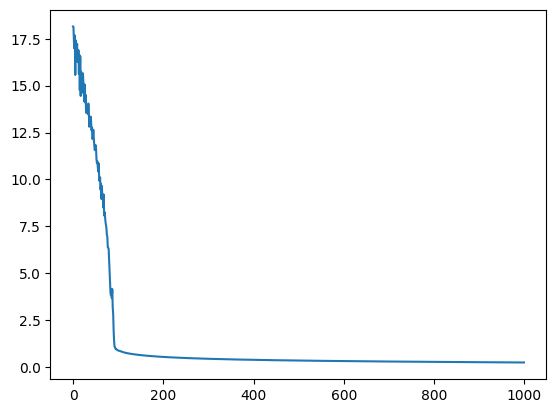

In [ ]:
np.random.seed(1)
n_x = 3
n_h = 100
n_y = 5
batch_size = 10
sequence_length = 50
x = np.random.randn(batch_size, sequence_length, n_x)
y = generate_one_hot_targets(batch_size, sequence_length, n_y)

network = RecurrentNeuralNetwork(n_x, n_y, n_h)
losses = train(network, x, y, learning_rate=0.01, max_iter=1000)
plt.plot(losses)
plt.show()